In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report,confusion_matrix,recall_score, precision_score,roc_auc_score
from sklearn.linear_model import LogisticRegression

from spacy.lang.en.stop_words import STOP_WORDS as sw

from matplotlib import pyplot as plt
import re
from wordcloud import WordCloud
import json
from sklearn.model_selection import GridSearchCV 
import spacy
from sklearn.model_selection import RepeatedStratifiedKFold
import warnings
from warnings import filterwarnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
restaurant = pd.read_csv('C:/res/res_reviews.txt', sep = '\t')

In [4]:
restaurant.shape

(1004, 2)

In [5]:
restaurant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 2 columns):
Review    1004 non-null object
Liked     1004 non-null int64
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
restaurant.describe()

,Liked
count,1004.000000
mean,0.500000
std,0.500249
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [7]:
restaurant['Liked'].value_counts()

1    502
0    502
Name: Liked, dtype: int64

### Text preprocessing

In [8]:
def special_char(x):
    x = re.sub(r'[^\w]+'," ",x)
    return x
    

In [9]:
def lower_case(x):
    x = str(x).lower()
    return x

In [10]:
def remove_url(x):
    x = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)
    return x

In [11]:
fill = open('contract_words.json','r')
contract_words = json.load(fill)
fill.close

<function TextIOWrapper.close()>

In [12]:
def cont_to_exp(x):
    if type(x) is str:
        for key in contract_words:
            value =contract_words[key]
            x = x.replace(key, value)
        return x
    else:
        return x

In [13]:
nlp = spacy.load('en_core_web_lg')

In [14]:
def make_to_base(x):
    x = str(x)
    x_list = []
    doc = nlp(x)
    
    for token in doc:
        lemma = token.lemma_
        if lemma == '-PRON-' or lemma == 'be':
            lemma = token.text

        x_list.append(lemma)
    return ' '.join(x_list)

In [15]:
def tokenizer(x):
    doc = nlp(x)
    for token in doc:
        print(token.text)

In [16]:
restaurant['Review'] = restaurant['Review'].apply(lambda x:lower_case(x).strip())

In [17]:
restaurant['Review'] = restaurant['Review'].apply(lambda x:make_to_base(x))

In [18]:
restaurant['Review'] = restaurant['Review'].apply(lambda x:cont_to_exp(x))

In [19]:
restaurant['Review'] = restaurant['Review'].apply(lambda x:special_char(x))

In [20]:
restaurant['Review'] = restaurant['Review'].apply(lambda x:remove_url(x).strip())

## fitting  my word2vec to the features

In [21]:
x = restaurant['Review']
y = restaurant['Liked']

In [22]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [23]:
restaurant['vec'] = restaurant['Review'].apply(lambda x: get_vec(x))

In [24]:
x = restaurant['vec'].to_numpy()

In [25]:
x = x.reshape(-1,1)

In [26]:
x = np.concatenate(np.concatenate(x, axis = 0),axis = 0).reshape(-1,300)

In [27]:
x.shape

(1004, 300)

## Splitting and Training my dataset

In [28]:
x_train,x_test,y_train,y_test = train_test_split(x,y, test_size = 0.2, stratify = y)

In [29]:
lr = LogisticRegression()

In [30]:
Solver = ['newton-cg','lbfgs','liblinear']
penalty = ['l2']
c_values = [100,10,1.0,0.1,0.01]

In [31]:
grid = dict(solver = Solver,penalty=penalty,C=c_values)

In [32]:
gridsearch = GridSearchCV(estimator=lr,param_grid=grid,n_jobs =-1,scoring='accuracy')

In [33]:
model = gridsearch.fit(x_train,y_train)

In [34]:
y_pred = model.predict(x_test)

In [35]:
from mlxtend.plotting import plot_confusion_matrix

In [36]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       101
           1       0.83      0.79      0.81       100

    accuracy                           0.82       201
   macro avg       0.82      0.82      0.82       201
weighted avg       0.82      0.82      0.82       201



In [48]:
print(f'best accuracy: {model.best_score_}\nbest_param: {model.best_params_}')

best accuracy: 0.8642546583850933
best_param: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}


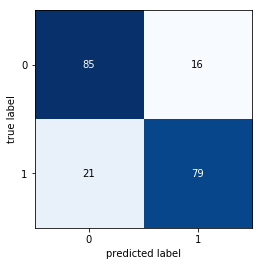

In [38]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred))
plt.show()

In [39]:
def get_pred(x):
    x = cont_to_exp(x)
    x = remove_url(x)
    x = make_to_base(x)
    x = lower_case(x)
    x = special_char(x)
    vec = get_vec(x).reshape(-1,1)
    vec = vec.reshape(1,300)
    y_pred = model.predict(vec)
    return y_pred

In [40]:
def word_plot(x):
    Ws = WordCloud(width = 500,height = 400).generate(str(x))
    plt.imshow(Ws)
    plt.show()

In [41]:
positive_words = restaurant.loc[restaurant['Liked']==1]

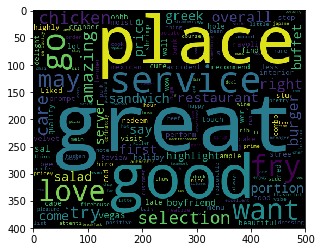

In [42]:
word_plot(positive_words)

In [43]:
negative_words = restaurant.loc[restaurant['Liked']==0]

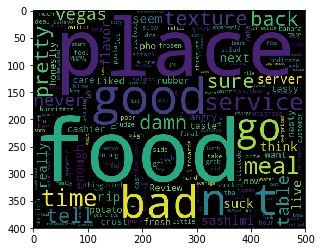

In [44]:
word_plot(negative_words)

In [45]:
x = 'Wow what a tasty meal meal'

In [46]:
get_pred(str(x))

array([1], dtype=int64)